# Introduction to scheduling

In this notebook, we explore how to solve a resource constrained project scheduling problem (RCPSP).

The problem is made of $M$ activities that have precedence constraints. That means that if activity $j\in[1,M]$ is a successor of activity $i\in[1,M]$, then activity $i$ must be completed before activity $j$ can be started

On top of these constraints, each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units.

Each activity $j$ takes $d_{j}$ time units to complete.

The overall goal of the problem is usually to minimize the makespan.

A classic variant of RCPSP is the multimode RCPSP where each task can be executed in several ways (one way=one mode). A typical example is :

- Mode n°1 'Fast mode': high resource consumption and fast
- Mode n°2 'Slow mode' : low resource consumption but slow

Concerning the python kernel to use for this notebook:
- If running locally, be sure to use an environment with scikit-decide[all] and minizinc.
- If running on colab, the next cell does it for you, and download the input file used for the last part.
- If running on binder, the environment should be ready.

In [ ]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import glob
    import importlib
    import json
    import os
    import sys

    using_nightly_version = True

    if using_nightly_version:
        # look for nightly build download url
        release_curl_res = !curl -L   -H "Accept: application/vnd.github+json" -H "X-GitHub-Api-Version: 2022-11-28" https://api.github.com/repos/airbus/scikit-decide/releases/tags/nightly
        release_dict = json.loads(release_curl_res.s)
        release_download_url = sorted(
            release_dict["assets"], key=lambda d: d["updated_at"]
        )[-1]["browser_download_url"]
        print(release_download_url)

        # download and unzip
        !wget --output-document=release.zip {release_download_url}
        !unzip -o release.zip

        # get proper wheel name according to python version used
        wheel_pythonversion_tag = f"cp{sys.version_info.major}{sys.version_info.minor}"
        wheel_path = glob.glob(
            f"dist/scikit_decide*{wheel_pythonversion_tag}*manylinux*.whl"
        )[0]

        skdecide_pip_spec = f"{wheel_path}[all]"
    else:
        skdecide_pip_spec = "scikit-decide[all]"

    # uninstall google protobuf conflicting with ray and sb3
    ! pip uninstall -y protobuf

    # install scikit-decide with all extras
    !pip install {skdecide_pip_spec}

    # be sure to load the proper cffi (downgraded compared to the one initially on colab)
    import cffi

    importlib.reload(cffi)

    # install and configure minizinc
    !curl -o minizinc.AppImage -L https://github.com/MiniZinc/MiniZincIDE/releases/download/2.6.3/MiniZincIDE-2.6.3-x86_64.AppImage
    !chmod +x minizinc.AppImage
    !./minizinc.AppImage --appimage-extract
    os.environ["PATH"] = f"{os.getcwd()}/squashfs-root/usr/bin/:{os.environ['PATH']}"
    os.environ[
        "LD_LIBRARY_PATH"
    ] = f"{os.getcwd()}/squashfs-root/usr/lib/:{os.environ['LD_LIBRARY_PATH']}"

    # download input file
    !wget https://raw.githubusercontent.com/airbus/scikit-decide/master/notebooks/j12052_1.sm

In [ ]:
# patching asyncio so that applications using async functions can run in jupyter
import nest_asyncio

nest_asyncio.apply()

import logging

logging.basicConfig(level=logging.INFO)

import time
from pprint import pprint

## A simple problem definition

Let start with a very simple problem which has only 5 tasks to execute:
All tasks have specific durations and they can consume 1 type of renewable resources.

Some tasks need to be executed after some have completed, for example:
 - Task 1 has 2 successors: task 2 and task 4
 - Task 2 has a single successor: Task 3
 - Task 3 and Task 4 have the same successor: Task 5
 - Task 5 has no successor
 
Task 0 & Task 5 have specific roles. The first one is called the source and the former the sink. They ususally have a zero duration.

In our problem, Tasks 2 & 3 have a duration of 3 while Task 4 has a duration of 7 units.

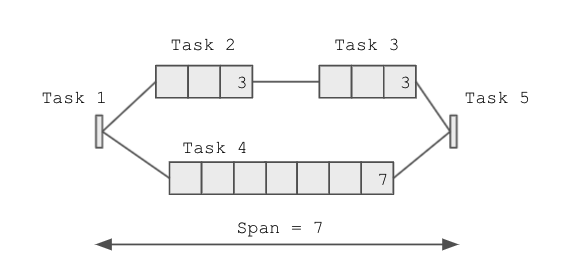

### Domain definition

We use the scheduling domain API provided in scikit-decide library under the ``skdecide.builders.domain.scheduling`` module. We will define an instance of ``SimpleModeRCPSP`` which is an model class that simplifies the implementation for the user. By implementing abstract methods of this model class, you end up by defining :
- the max horizon : ```_get_max_horizon```
- successor graph : ```_get_successors```
- tasks id's : ```_get_tasks_id```
- tasks description where you define the resource consumption : ```_get_tasks_mode```
- resource names ```_get_resource_types_names```
- resource quantity ```_get_original_quantity_resource```
- objective function to minimize ```_get_objectives``` (only MAKESPAN currently makes sense)
- duration of the tasks ```_get_task_duration```

In the implementation of _get_tasks_mode, the class `ConstantModeConsumption` was used indicating that each task is consuming the same constant amount of resources for the entire duration of its execution. Chosing `VaryingModeConsumption` allows a different resource consumption profile during the execution of a task.

In [ ]:
from typing import Any, Dict, List, Optional, Set, Union

from skdecide import rollout_episode
from skdecide.builders.domain.scheduling.modes import (
    ConstantModeConsumption,
    ModeConsumption,
)
from skdecide.builders.domain.scheduling.scheduling_domains import (
    SchedulingObjectiveEnum,
    SingleModeRCPSP,
)


class VerySimple_RCPSPDomain(SingleModeRCPSP):
    def __init__(self):
        self.initialize_domain()

    def _get_objectives(self) -> List[SchedulingObjectiveEnum]:
        return [SchedulingObjectiveEnum.MAKESPAN]

    def _get_max_horizon(self) -> int:
        return 10

    def _get_successors(self) -> Dict[int, List[int]]:
        return {
            1: [2, 4],
            2: [3],
            3: [5],
            4: [5],
            5: [],
        }

    def _get_tasks_ids(self) -> Union[Set[int], Dict[int, Any], List[int]]:
        return set([*range(1, 6)])

    def _get_tasks_mode(self) -> Dict[int, ModeConsumption]:
        return {
            1: ConstantModeConsumption({"r1": 0}),
            2: ConstantModeConsumption({"r1": 4}),
            3: ConstantModeConsumption({"r1": 1}),
            4: ConstantModeConsumption({"r1": 0}),
            5: ConstantModeConsumption({"r1": 0}),
        }

    def _get_resource_types_names(self) -> List[str]:
        return ["r1"]

    def _get_task_duration(
        self, task: int, mode: Optional[int] = 1, progress_from: Optional[float] = 0.0
    ) -> int:
        all_durations = {1: 0, 2: 3, 3: 3, 4: 7, 5: 0}
        return all_durations[task]

    def _get_original_quantity_resource(self, resource: str, **kwargs) -> int:
        all_resource_quantities = {"r1": 7}

        return all_resource_quantities[resource]

### Let's create an instance of this domain

In [ ]:
domain = VerySimple_RCPSPDomain()
domain.set_inplace_environment(False)
state = domain.get_initial_state()

By only defining the function, the library is automatically building a planning domain like it is commonly used in scikit-decide (implementing ```get_next_state```, ```get_applicable_action``` functions notably)

Let's see what is stored in the initial state for this `scikit-decide` domain : 

In [ ]:
print(f" The state contains the following field:")
pprint([x for x in dir(state) if not x.startswith("_")])

Let's check some of those attributes:

In [ ]:
print(f"Current state time: {state.t}")

In [ ]:
print(
    f"{len(set(state.tasks_remaining))} tasks over {len(state.task_ids)} are still unscheduled"
)

Then one can get details for each of the tasks. For example, `task 1` has the following status:

In [ ]:
print(f"{state.tasks_full_details[1]}")

As you see, the state is storing everything needed to follow the status of each task at a given time $t$. Solving a scheduling domain will mean to trigger task start at the right time and advancing in time. The available action in a given state are split in 2 types : 
- Start a task in a given mode
- Advance in time

For the initial state, here are the two possible actions:

In [ ]:
print(
    "\n\n".join([str(a) for a in domain.get_applicable_actions(state).get_elements()])
)

### Using  Lazy Astar to solve this problem

One could try to use a classical planning solver like A* to solve this statefull domain. 

In [ ]:
from skdecide.hub.solver.lazy_astar import LazyAstar

solver = LazyAstar(from_state=state, heuristic=None)
solver.solve(domain_factory=lambda: domain)

### Result analysis

The solver has generated a policy for this scheduling problem. Now we can apply the policy to the domain and chack what is the final state. The policy is usually applied through the `rollout_episode` function but let's do it manually this time.

In [ ]:
from skdecide.builders.domain import Goals

has_goal = isinstance(domain, Goals)

# Initialize episode
solver.reset()

domain.set_memory(state)
observation = domain.get_observation_distribution(state, None).sample()

step = 1

states = []
# save the initial observation
states.append(observation)

while step <= 500:
    # Get Action
    action = solver.sample_action(observation)
    # Get action outcome
    outcome = domain.step(action)
    # Extract observation
    observation = outcome.observation
    states.append(observation)

    if outcome.termination:
        logging.info(f" Episode terminated after {step + 1} steps.")
        break

    step += 1

if has_goal:
    logging.info(
        f' The goal was{"" if domain.is_goal(observation) else " not"} reached'
    )

Let's now get the final state.

In [ ]:
final_state = states[-1]

The makespan of our workflow is the latest time or the end time of the `task 5`. Both should be equal.

In [ ]:
print(
    f"Time of last state: {final_state.t} - Ending time of Task #5: {final_state.tasks_full_details[5].end}"
)

## A slightly more complex problem

Now we want to solve a 32 tasks problem which is describe in the following class.

### Problem definition

In [ ]:
class J301_RCPSPDomain(SingleModeRCPSP):
    def __init__(self):
        self.initialize_domain()

    def _get_objectives(self) -> List[SchedulingObjectiveEnum]:
        return [SchedulingObjectiveEnum.MAKESPAN]

    def _get_max_horizon(self) -> int:
        return 158

    def _get_successors(self) -> Dict[int, List[int]]:
        return {
            1: [2, 3, 4],
            2: [6, 11, 15],
            3: [7, 8, 13],
            4: [5, 9, 10],
            5: [20],
            6: [30],
            7: [27],
            8: [12, 19, 27],
            9: [14],
            10: [16, 25],
            11: [20, 26],
            12: [14],
            13: [17, 18],
            14: [17],
            15: [25],
            16: [21, 22],
            17: [22],
            18: [20, 22],
            19: [24, 29],
            20: [23, 25],
            21: [28],
            22: [23],
            23: [24],
            24: [30],
            25: [30],
            26: [31],
            27: [28],
            28: [31],
            29: [32],
            30: [32],
            31: [32],
            32: [],
        }

    def _get_tasks_ids(self) -> Union[Set[int], Dict[int, Any], List[int]]:
        return set([*range(1, 33)])

    def _get_tasks_mode(self) -> Dict[int, ModeConsumption]:
        return {
            1: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 0}),
            2: ConstantModeConsumption({"r1": 4, "r2": 0, "r3": 0, "r4": 0}),
            3: ConstantModeConsumption({"r1": 10, "r2": 0, "r3": 0, "r4": 0}),
            4: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 3}),
            5: ConstantModeConsumption({"r1": 3, "r2": 0, "r3": 0, "r4": 0}),
            6: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 8}),
            7: ConstantModeConsumption({"r1": 4, "r2": 0, "r3": 0, "r4": 0}),
            8: ConstantModeConsumption({"r1": 0, "r2": 1, "r3": 0, "r4": 0}),
            9: ConstantModeConsumption({"r1": 6, "r2": 0, "r3": 0, "r4": 0}),
            10: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 1}),
            11: ConstantModeConsumption({"r1": 0, "r2": 5, "r3": 0, "r4": 0}),
            12: ConstantModeConsumption({"r1": 0, "r2": 7, "r3": 0, "r4": 0}),
            13: ConstantModeConsumption({"r1": 4, "r2": 0, "r3": 0, "r4": 0}),
            14: ConstantModeConsumption({"r1": 0, "r2": 8, "r3": 0, "r4": 0}),
            15: ConstantModeConsumption({"r1": 3, "r2": 0, "r3": 0, "r4": 0}),
            16: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 5}),
            17: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 8}),
            18: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 7}),
            19: ConstantModeConsumption({"r1": 0, "r2": 1, "r3": 0, "r4": 0}),
            20: ConstantModeConsumption({"r1": 0, "r2": 10, "r3": 0, "r4": 0}),
            21: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 6}),
            22: ConstantModeConsumption({"r1": 2, "r2": 0, "r3": 0, "r4": 0}),
            23: ConstantModeConsumption({"r1": 3, "r2": 0, "r3": 0, "r4": 0}),
            24: ConstantModeConsumption({"r1": 0, "r2": 9, "r3": 0, "r4": 0}),
            25: ConstantModeConsumption({"r1": 4, "r2": 0, "r3": 0, "r4": 0}),
            26: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 4, "r4": 0}),
            27: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 7}),
            28: ConstantModeConsumption({"r1": 8, "r2": 8, "r3": 0, "r4": 0}),
            29: ConstantModeConsumption({"r1": 7, "r2": 7, "r3": 0, "r4": 0}),
            30: ConstantModeConsumption({"r1": 7, "r2": 7, "r3": 0, "r4": 0}),
            31: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 2, "r4": 0}),
            32: ConstantModeConsumption({"r1": 0, "r2": 0, "r3": 0, "r4": 0}),
        }

    def _get_resource_types_names(self) -> List[str]:
        return ["r1", "r2", "r3", "r4"]

    def _get_task_duration(
        self, task: int, mode: Optional[int] = 1, progress_from: Optional[float] = 0.0
    ) -> int:
        all_durations = {
            1: 0,
            2: 8,
            3: 4,
            4: 6,
            5: 3,
            6: 8,
            7: 5,
            8: 9,
            9: 2,
            10: 7,
            11: 9,
            12: 2,
            13: 6,
            14: 3,
            15: 9,
            16: 10,
            17: 6,
            18: 5,
            19: 3,
            20: 7,
            21: 2,
            22: 7,
            23: 2,
            24: 3,
            25: 3,
            26: 7,
            27: 8,
            28: 3,
            29: 7,
            30: 2,
            31: 2,
            32: 0,
        }
        return all_durations[task]

    def _get_original_quantity_resource(self, resource: str, **kwargs) -> int:
        all_resource_quantities = {"r1": 12, "r2": 13, "r3": 14, "r4": 12}

        return all_resource_quantities[resource]

### Create an instance of the J301 domain

In [ ]:
domain = J301_RCPSPDomain()
domain.set_inplace_environment(False)
state = domain.get_initial_state()

### Lazy Astar to solve this problem

One could try again to use classical planning solver like A* to solve this statefull domain. However due to an exploding search space, it is not tractable again for a problem with more than a few tasks.

To convince yourself, you can run the following which has a 300 seconds time-out.

In [ ]:
import signal

from skdecide.hub.solver.lazy_astar import LazyAstar


def handler(signum, frame):
    raise Exception("Time out")


signal.signal(signal.SIGALRM, handler)

# Wait for 300 seconds
signal.alarm(300)

solver = LazyAstar(from_state=state, heuristic=None)
try:
    solver.solve(domain_factory=lambda: domain)
except Exception:
    print("the algorithm could not finish")
finally:
    signal.alarm(0)

### Let's now use a CP solver

One of the state-of-art method to solve RCPSP problem is by using Constraint programming  (https://en.wikipedia.org/wiki/Constraint_programming), an Operational research method that explores the state variables and propagate constraints in a clever way. 
In constraint programming, users declaratively state the constraints on the feasible solutions for a set of decision variables. Constraints specify the properties of a solution to be found. The CP model we are using is available at ```skdecide/discrete_optimization/rcpsp/minizinc/rcpsp_single_mode_mzn.mzn```.
The underlying library we are using is [MiniZinc](https://www.minizinc.org) and the CP solver backend [CHUFFED](https://github.com/chuffed/chuffed).

In [ ]:
from discrete_optimization.generic_tools.cp_tools import ParametersCP

from skdecide.hub.solver.do_solver.do_solver_scheduling import (
    BasePolicyMethod,
    DOSolver,
    PolicyMethodParams,
    SolvingMethod,
)

In [ ]:
logging.info("Solving with CP")
dict_params = {}
params_cp = ParametersCP.default()
params_cp.TimeLimit = 300
dict_params["parameters_cp"] = params_cp
policy_method_params = PolicyMethodParams(
    base_policy_method=BasePolicyMethod.FOLLOW_GANTT,
    delta_index_freedom=0,
    delta_time_freedom=0,
)
solver = DOSolver(
    policy_method_params=policy_method_params,
    method=SolvingMethod.CP,
    dict_params=dict_params,
)
# possible_solvers = look_for_solver(domain)
# logging.info(f"Possible solvers: {[str(solver[0]).split('.')[-1][:-2] for solver in possible_solvers]}")
tic = time.perf_counter()
solver.solve(domain_factory=lambda: domain)
toc = time.perf_counter()
logging.info(f"Computing Time: {toc - tic:0.4f} seconds")

# logging.info(solver.best_solution.rcpsp_schedule)
logging.info(solver.do_domain.evaluate(solver.best_solution))

We can now execute the resulting policy using the `rollout_episode` and check the result. 

In [ ]:
states, _, _ = rollout_episode(
    domain=domain,
    solver=solver,
    from_memory=state,
    max_steps=500,
    verbose=False,
    outcome_formatter=None,
    action_formatter=None,
)

In [ ]:
final_state = states[-1]

The makespan of our workflow is the latest time or the end time of the `task 32`. Both should be equal.

In [ ]:
print(
    f"Time of last state: {final_state.t} - Ending time of Task #32: {final_state.tasks_full_details[32].end}"
)

### Plotting the solution
We rely on discrete_optimization plot utilities (where the CP model is used) to plot the gantt chart of our solution.

In [ ]:
from skdecide.hub.solver.do_solver.sk_to_do_binding import from_last_state_to_solution

do_sol = from_last_state_to_solution(states[-1], domain)
from discrete_optimization.rcpsp.rcpsp_utils import plot_ressource_view, plot_task_gantt

# Each line of the plot is a task
fig_gantt = plot_task_gantt(do_sol.problem, do_sol)
# Plot resource consumption plot
fig_resource = plot_ressource_view(do_sol.problem, do_sol)

### Intermediate Conclusion
On a problem containing only 32 tasks, an algorithm like $A^{*}$ cannot find a solution while a constraint programming approach takes less than half a second. Let's see what happen on a larger problem. 

## Going further : a bigger RCPSP problem

### Psplib files
We rely on psplib benchmark files (http://www.om-db.wi.tum.de/psplib/) which containts sets of instances of 30, 60, 90 and 120 activities.
We will now use the ```j12051_1``` file that we identified as a difficult one to solve.

#### psplib format 

The following cell will open a new tab with the `sm` file. On colab, you should rather click on [that link](j12052_1.sm) to see it.

You can explore the structure of the file : 
- At the top part of the file : the number of jobs, horizon of scheduling and resource description are given.
- The `PRECEDENCE RELATIONS` subpart gives for each tasks, the ids of their successors,
- The `REQUESTS/DURATIONS` part specifies for each task its duration and consumption of each resource.
- RESOURCEAVAILABILITIES : everything is in the title 

In [ ]:
import os
import webbrowser

webbrowser.open("file:///" + os.path.realpath("j12052_1.sm"))

#### Parsing a psplib file 
We provide a parser for this files so that it is automatically transformed into a RCPSP domain in scikit-decide.

In [ ]:
from skdecide.hub.domain.rcpsp.rcpsp_sk import RCPSP
from skdecide.hub.domain.rcpsp.rcpsp_sk_parser import load_domain

In [ ]:
big_domain: RCPSP = load_domain("j12052_1.sm")
big_domain.set_inplace_environment(False)

### Using a CP solver again

We will run CP solver with a timeout of 5 minutes.

In [ ]:
state = big_domain.get_initial_state()
base_policy_method = BasePolicyMethod.FOLLOW_GANTT
policy_method_params = PolicyMethodParams(
    base_policy_method=base_policy_method, delta_index_freedom=0, delta_time_freedom=0
)
# We want to focus on CP
method = SolvingMethod.CP
# Let's define the parameters for our CP solver
dict_params = {}
params_cp = ParametersCP.default()
# Let's change the 30 seconds default to something bigger
params_cp.TimeLimit = 300
dict_params["parameters_cp"] = params_cp
# Let's create our solver with the given feature
solver = DOSolver(
    policy_method_params=policy_method_params, method=method, dict_params=dict_params
)
tic = time.perf_counter()
solver.solve(domain_factory=lambda: big_domain)
toc = time.perf_counter()
makespan = solver.do_domain.evaluate(solver.best_solution)["makespan"]
cp_solution = solver.best_solution.copy()
print(f"CP achieved a {makespan} makespan in: {toc - tic:0.4f} seconds")

### Using the Large Neighboorhood Search algorithm

Local search techniques are very effective to solve hard optimization problems. In the context of constraint programming (CP) for optimization problems, one of the most well-known and widely used local search techniques is the Large Neighborhood Search (LNS) algorithm . The basic idea is to iteratively relax a part of the problem, then to use constraint programming to optimize a simpler problem hoping that the reconstructed full solution improve our objective function.
For more insight, you can read this paper [\[1\]](https://www.researchgate.net/publication/220462078_LSSPER_Solving_the_Resource-Constrained_Project_Scheduling_Problem_with_Large_Neighbourhood_Search)

In [ ]:
state = big_domain.get_initial_state()

base_policy_method = BasePolicyMethod.FOLLOW_GANTT

policy_method_params = PolicyMethodParams(
    base_policy_method=base_policy_method, delta_index_freedom=0, delta_time_freedom=0
)

# This time, we want to focus on LNS_CP
method = SolvingMethod.LNS_CP

dict_params = {}

# We will use the default TimeLimit value for the internal CP solver
# This value is 30 seconds
params_cp = ParametersCP.default()
params_cp.TimeLimit = 30

# To be consistent with the previous solve we will cap the overall
# time to the same 300 seconds limit
dict_params["parameters_cp"] = params_cp
dict_params["max_time_seconds"] = 300
dict_params[
    "nb_iteration_lns"
] = 10000  # dummy value, we want that the max_time_seconds to be the limiting param
dict_params["verbose"] = False

# Let's create our solver with the given feature
# This step is mostly similar to the previous one
solver = DOSolver(
    policy_method_params=policy_method_params, method=method, dict_params=dict_params
)

tic = time.perf_counter()
solver.solve(domain_factory=lambda: big_domain)
toc = time.perf_counter()
lns_cp_solution = solver.best_solution.copy()
makespan = solver.do_domain.evaluate(solver.best_solution)["makespan"]
print(f"LNS-CP achieved a {makespan} makespan in: {toc - tic:0.4f} seconds")

## Conclusion

In this notebook, we have seen how to use [scikit-decide](https://airbus.github.io/scikit-decide) to plan tasks. The library offers a binding to a constraint programming (CP) based solver providing optimal solution on small and mid sized benchmark. It reaches its limit for instances with >100 tasks where the use of the approximated solver LNS+CP  proves to be effective.